In [20]:
import spacy
import random
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline

from pickle import dump,load
from random import randint

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

with open("moby_dick_four_chapters.txt") as f:
    doc = f.read()

In [2]:
# loading spacy model for preprocessing the text
nlp = spacy.load('en_core_web_sm',disable=['parser', 'tagger','ner'])

# Gives error if length> 1m so text length needs to be set explicitly
nlp.max_length = 1198623

In [3]:
# function to clean unnecessary tokens that d cause overfitting

def clean_text(doc):
    return [token.text.lower() for token in nlp(doc) if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n ']

In [4]:
tokens = clean_text(doc)

In [5]:
len(tokens)

11394

In [6]:
# creating sequences of tokens

# 25 training words , then one target word
train_len = 25+1 

text_sequences = []

for i in range(train_len, len(tokens)):
    
    # grabbing train_len 26 words
    seq = tokens[i-train_len:i]
    
    # adding to list of sequences
    text_sequences.append(seq)

In [7]:
len(text_sequences)

11368

In [8]:
text_sequences[0]

['call',
 'me',
 'ishmael',
 'some',
 'years',
 'ago',
 'never',
 'mind',
 'how',
 'long',
 'precisely',
 'having',
 'little',
 'or',
 'no',
 'money',
 'in',
 'my',
 'purse',
 'and',
 'nothing',
 'particular',
 'to',
 'interest',
 'me',
 'on']

In [9]:
# integer encoding words in sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)

In [10]:
# replaced words in text with particular ids 
# sequences with shifting one word over
sequences = np.array(sequences)
sequences[:10].T

array([[ 964,   14,  265,   51,  263,  416,   87,  222,  129,  111],
       [  14,  265,   51,  263,  416,   87,  222,  129,  111,  962],
       [ 265,   51,  263,  416,   87,  222,  129,  111,  962,  262],
       [  51,  263,  416,   87,  222,  129,  111,  962,  262,   50],
       [ 263,  416,   87,  222,  129,  111,  962,  262,   50,   43],
       [ 416,   87,  222,  129,  111,  962,  262,   50,   43,   37],
       [  87,  222,  129,  111,  962,  262,   50,   43,   37,  321],
       [ 222,  129,  111,  962,  262,   50,   43,   37,  321,    7],
       [ 129,  111,  962,  262,   50,   43,   37,  321,    7,   23],
       [ 111,  962,  262,   50,   43,   37,  321,    7,   23,  555],
       [ 962,  262,   50,   43,   37,  321,    7,   23,  555,    3],
       [ 262,   50,   43,   37,  321,    7,   23,  555,    3,  150],
       [  50,   43,   37,  321,    7,   23,  555,    3,  150,  261],
       [  43,   37,  321,    7,   23,  555,    3,  150,  261,    6],
       [  37,  321,    7,   23,  5

In [11]:
# splitting training and target sequences
X = sequences[:,:-1]
y = sequences[:,-1]

In [12]:
vocabulary_size = len(tokenizer.word_counts)
vocabulary_size

2709

In [13]:
# keras padding sequences need an extra space to hold zero
y = to_categorical(y, num_classes=vocabulary_size+1) 

In [14]:
seq_len = X.shape[1] # setting seq_len = 25

In [15]:
def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size+1,output_dim=seq_len,input_length=seq_len))
    model.add(LSTM(seq_len*2, return_sequences=True))
    model.add(LSTM(seq_len*2))
    model.add(Dense(seq_len*6, activation='relu'))

    model.add(Dense(vocabulary_size+1, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    model.summary()
    
    return model

In [16]:
model = create_model(vocabulary_size,seq_len)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 25)            67750     
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 50)            15200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
_________________________________________________________________
dense_2 (Dense)              (None, 2710)              409210    
Total params: 520,010
Trainable params: 520,010
Non-trainable params: 0
_________________________________________________________________


In [18]:
# fit model
history = model.fit(X, y, batch_size=128, epochs=200,verbose=1)

Epoch 1/200
11368/11368 [==============================] - 4s 347us/step - loss: 6.2718 - acc: 0.0527
Epoch 2/200
11368/11368 [==============================] - 4s 346us/step - loss: 6.1578 - acc: 0.0527
Epoch 3/200
11368/11368 [==============================] - 4s 353us/step - loss: 6.0933 - acc: 0.0527 1s - loss: 6.0998 - acc: 0.05 - ETA: 1s - loss: 
Epoch 4/200
11368/11368 [==============================] - 4s 348us/step - loss: 5.9862 - acc: 0.0544
Epoch 5/200
11368/11368 [==============================] - 4s 353us/step - loss: 5.8850 - acc: 0.0560
Epoch 6/200
11368/11368 [==============================] - 5s 400us/step - loss: 5.8134 - acc: 0.0663
Epoch 7/200
11368/11368 [==============================] - 5s 415us/step - loss: 5.7466 - acc: 0.0669
Epoch 8/200
11368/11368 [==============================] - 5s 423us/step - loss: 5.6895 - acc: 0.0678
Epoch 9/200
11368/11368 [==============================] - 5s 405us/step - loss: 5.6288 - acc: 0.0704
Epoch 10/200
11368/11368 [=======

11368/11368 [==============================] - 5s 422us/step - loss: 2.6877 - acc: 0.3557
Epoch 81/200
11368/11368 [==============================] - 5s 428us/step - loss: 2.6665 - acc: 0.3588
Epoch 82/200
11368/11368 [==============================] - 5s 431us/step - loss: 2.6380 - acc: 0.3629
Epoch 83/200
11368/11368 [==============================] - 5s 429us/step - loss: 2.6052 - acc: 0.3681
Epoch 84/200
11368/11368 [==============================] - 5s 432us/step - loss: 2.5736 - acc: 0.3757
Epoch 85/200
11368/11368 [==============================] - 5s 445us/step - loss: 2.5422 - acc: 0.3836
Epoch 86/200
11368/11368 [==============================] - 5s 449us/step - loss: 2.5100 - acc: 0.3841
Epoch 87/200
11368/11368 [==============================] - 5s 453us/step - loss: 2.4780 - acc: 0.4007
Epoch 88/200
11368/11368 [==============================] - 5s 459us/step - loss: 2.4604 - acc: 0.3987
Epoch 89/200
11368/11368 [==============================] - 5s 453us/step - loss: 2.43

Epoch 158/200
11368/11368 [==============================] - 9s 759us/step - loss: 1.1385 - acc: 0.7050
Epoch 159/200
11368/11368 [==============================] - 9s 757us/step - loss: 1.1145 - acc: 0.7114
Epoch 160/200
11368/11368 [==============================] - 9s 758us/step - loss: 1.1062 - acc: 0.7135
Epoch 161/200
11368/11368 [==============================] - 9s 760us/step - loss: 1.0955 - acc: 0.7168
Epoch 162/200
11368/11368 [==============================] - 9s 763us/step - loss: 1.0783 - acc: 0.7222
Epoch 163/200
11368/11368 [==============================] - 9s 766us/step - loss: 1.0932 - acc: 0.7169
Epoch 164/200
11368/11368 [==============================] - 9s 772us/step - loss: 1.0596 - acc: 0.7247
Epoch 165/200
11368/11368 [==============================] - 9s 787us/step - loss: 1.0647 - acc: 0.7196
Epoch 166/200
11368/11368 [==============================] - 9s 783us/step - loss: 1.0324 - acc: 0.7308
Epoch 167/200
11368/11368 [==============================] - 9s 

dict_keys(['loss', 'acc'])


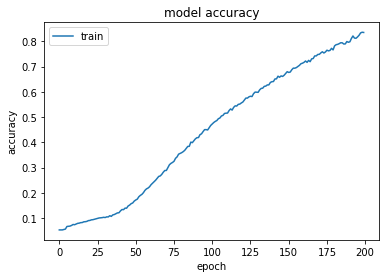

In [27]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
# save the model to file
model.save('epoch_200.h5')

# save the tokenizer
dump(tokenizer, open('tokenizer', 'wb'))

In [28]:
seed_text = ' '.join(text_sequences[0])

In [29]:
seed_text

'call me ishmael some years ago never mind how long precisely having little or no money in my purse and nothing particular to interest me on'

In [30]:
tokenizer.texts_to_sequences([seed_text])

[[964,
  14,
  265,
  51,
  263,
  416,
  87,
  222,
  129,
  111,
  962,
  262,
  50,
  43,
  37,
  321,
  7,
  23,
  555,
  3,
  150,
  261,
  6,
  2704,
  14,
  24]]

In [31]:
# function to generate specific number of words followings a seed text

def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words):

    output_text = []
    
    for i in range(num_gen_words):
        
        encoded_text = tokenizer.texts_to_sequences([seed_text])[0]
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
        pred_word_ind = model.predict_classes(pad_encoded, verbose=0)[0]
        pred_word = tokenizer.index_word[pred_word_ind] 
        
        seed_text += ' ' + pred_word
        
        output_text.append(pred_word)
        
    return ' '.join(output_text)

In [32]:
generate_text(model,tokenizer,seq_len,seed_text=seed_text,num_gen_words=25)

'shore i account trying that that the indecorous floor and hunted up the blackness i does trying to be peddling venture on a bed side'